## Clustering of the courses 

### Downloading relevant libraries

In [1]:
import sys

!{sys.executable} -m spacy download en_core_web_lg 

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=e4699938ab574f7a98771ed33e6560b7e55b8e23df5c380fb3cc46b45a6e7ea7
  Stored in directory: /tmp/pip-ephem-wheel-cache-8bsk4z40/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
!{sys.executable} -m pip install umap-learn

In [ ]:
!{sys.executable} -m pip install hdbscan

In [2]:
!{sys.executable} -m pip install wordcloud

In [4]:
import pandas as pd
import re
import math
import spacy
import string
import numpy as np
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import en_core_web_sm
from math import floor, sqrt
from nltk import ngrams
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
import umap
import umap.umap_ as umap
import seaborn as sns
import hdbscan
from sklearn.manifold import TSNE

### Read the required CSV files
1. Containing Universities
2. Containing Online Courses

In [5]:
d = pd.read_csv("Course Descriptions - Tabellenblatt2-2.csv")

In [6]:
dff = pd.read_csv("MIE1624 - Group Project Course Curriculum.csv")

### Bringing the datasets into the same format

Drop not required Lables

In [7]:
d=d.drop(labels="Credits", axis=1)

In [8]:
dff=dff.drop(labels="Coursera", axis=1)

In [9]:
dfff=dff.drop(labels="Skills", axis=1)

In [10]:
dfff

,Course Name,Company,Course Description,Topics
0,Introduction to Data Science Specialization,IBM,Interested in learning more about data science...,Describe what data science and machine learnin...
1,Introduction to Data Science in Python,University of Michigan,This course will introduce the learner to the ...,Understand techniques such as lambdas and mani...
2,Introduction to Data Analytics,IBM,This course presents a gentle introduction int...,NaN
3,Applied Data Science with Python Specialization,University of Michigan,The 5 courses in this University of Michigan s...,Conduct an inferential statistical analysis\n\...
4,Data Analysis Using Python,University of Pennsylvania,This course provides an introduction to basic ...,Apply basic data science techniques using Pyth...
...,...,...,...,...
68,Big Data Analytics Using Spark,UC San Diego,"In data science, data is called ""big"" if it ca...",Programming Spark using Pyspark\nIdentifying t...
69,Data Science: Computational Thinking with Python,Berkeley,We live in an era of unprecedented access to d...,"Basics of the Python programming language, and..."
70,Statistical Thinking for Data Science and Anal...,Columbia,This statistics and data analysis course will ...,Week 1 – Introduction to Data Science\n\nWeek ...
71,Introduction to Computational Thinking and Dat...,MIT,6.00.2x will teach you how to use computation ...,Advanced programming in Python 3\nKnapsack pro...


Rename Columns uniformly

In [11]:
dfff=dfff.rename(columns={"Course Name":"Course Title", "Company": "University", "Course Description": "Short Description", "Topics":"Syllabus"})

Reorder columns

In [12]:
column_names = ["University", "Course Title","Short Description","Syllabus"]

In [13]:
dfff=dfff.reindex(columns=column_names)

Combine Dataframes

In [14]:
df=pd.concat([d,dfff])

In [15]:
df

,University,Course Title,Short Description,Syllabus
0,University of British Columbia,Porgramming for Data Science,Program design and data manipulation with Pyth...,Pseudo-code. Program design and structure. Flo...
1,University of British Columbia,Computing Platforms for Data Science,"How to install, maintain, and use the data sci...","ntroduction to software, shells, tools, and fi..."
2,University of British Columbia,Programming for Data Manipulation,Program design and data manipulation with R. O...,Program design and data manipulation using ind...
3,University of British Columbia,Fundamental concepts in probability including ...,Fundamental concepts in probability including ...,Descriptive statistics including measures of l...
4,University of British Columbia,Algorithms and Data Structures,How to choose and use appropriate algorithms a...,Basic algorithms. Recursion. Data structures i...
...,...,...,...,...
68,UC San Diego,Big Data Analytics Using Spark,"In data science, data is called ""big"" if it ca...",Programming Spark using Pyspark\nIdentifying t...
69,Berkeley,Data Science: Computational Thinking with Python,We live in an era of unprecedented access to d...,"Basics of the Python programming language, and..."
70,Columbia,Statistical Thinking for Data Science and Anal...,This statistics and data analysis course will ...,Week 1 – Introduction to Data Science\n\nWeek ...
71,MIT,Introduction to Computational Thinking and Dat...,6.00.2x will teach you how to use computation ...,Advanced programming in Python 3\nKnapsack pro...


### Preprocessing
Defining functions for preprocessing
Including: Lowercasing, removing punctzation and word counting

In [16]:
def preprocess_text(narrative):
    narrative = narrative.translate(str.maketrans('', '', string.punctuation))
    _RE_COMBINE_WHITESPACE = re.compile(r"\s+")
    narrative = _RE_COMBINE_WHITESPACE.sub(" ", narrative).strip()
    narrative = narrative.lower()
    return narrative

In [17]:
def handle_punctuation(text):
    return re.sub(r'(?<=[?.,!")])(?=[^\s])', r' ', text)



In [18]:
def get_number_unique_words(narratives):
    count_vectorizer = CountVectorizer()
    X = count_vectorizer.fit_transform(narratives)
    return len(count_vectorizer.get_feature_names())

Applying the preprocessing

In [19]:
df["Syllabus_punct"] =df["Syllabus"]

df["Syllabus_punct"] = df["Syllabus_punct"].astype(str).apply(handle_punctuation)
df["Description_punct"]=df["Short Description"].astype(str).apply(handle_punctuation)

syllabi = [syllabus for syllabus in df.loc[:, "Syllabus_punct"]] 
descriptions = [description for description in df.loc[:, "Description_punct"]] 

Tokenization and Stop Word removal
Words are first separated in tokens and then the stop words from a list of most common english words are removed. Later it was considered to remove words that are common in every document such as data. However, it was determined that the words would distort the analysis. For example the word data was very frequent but when it would be removed the cluster regarding databases etc. would be lost combined with the insights taken from this. 

In [20]:

nlp = en_core_web_sm.load()

In [21]:
nlp.disable_pipes('ner')
print(nlp.pipe_names)

['tagger', 'parser']


In [22]:
def spacy_tokenizer(tex):
    tokens = nlp(tex)
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    tokens = [word for word in tokens if word not in stopwords and word not in punctuations]
    tokens = " ".join([token for token in tokens])
    return tokens

In [23]:
stopwords = list(STOP_WORDS)
punctuations = string.punctuation

In [24]:
df["Processed_Syllabus"] = df["Syllabus_punct"].apply(spacy_tokenizer)
df["Processed_Description"]=df["Description_punct"].apply(spacy_tokenizer)

Vectorization using TF-IDF Vectorizer
Representing words in the form of their term frequency and inverse document frequency. (Overall appearance and number of documents they appeared in).

In [25]:

def vectorize(text, max_features):    
    vectorizer = TfidfVectorizer(max_features = max_features)
    X = vectorizer.fit_transform(text)
    return X

In [26]:
text = df["Processed_Syllabus"].values
# max features is the maximum number of unique words out of all of narratives
max_features = get_number_unique_words(syllabi)

X = vectorize(text, max_features)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Clustering
First the dimensions of the embeddings are reduced. Therfor the UMAP algorithm is used. 

In [28]:

num_posts = X.shape[0]
number_clusters = floor(sqrt(num_posts))

In [30]:


umap_embeddings = umap.UMAP(n_neighbors = 15, 
                            n_components = 5,
                            min_dist=0.0,
                            metric='cosine').fit_transform(X)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Clustering using HDBScan

In [32]:

cluster = hdbscan.HDBSCAN(metric = 'euclidean',
                          min_cluster_size = 10,
                          cluster_selection_method='eom').fit(umap_embeddings)  

In [33]:
clusters = cluster.labels_.tolist()

In [34]:
y_pred = np.array(clusters) 

In [35]:
frame = df

In [36]:
frame ["Clusters"]=clusters

In [37]:
no_clusters = len(set(frame.Clusters))

## Visualization
T-SNE is required to enable the low dimensional visualization

In [39]:
tsne = TSNE(verbose = 1, perplexity = 50)  
X_embedded = tsne.fit_transform(X.toarray())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 374 samples in 0.001s...
[t-SNE] Computed neighbors for 374 samples in 0.038s...
[t-SNE] Computed conditional probabilities for sample 374 / 374
[t-SNE] Mean sigma: 0.319957
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.411358
[t-SNE] KL divergence after 1000 iterations: 0.997838


Seaborn is used to create scatter plots

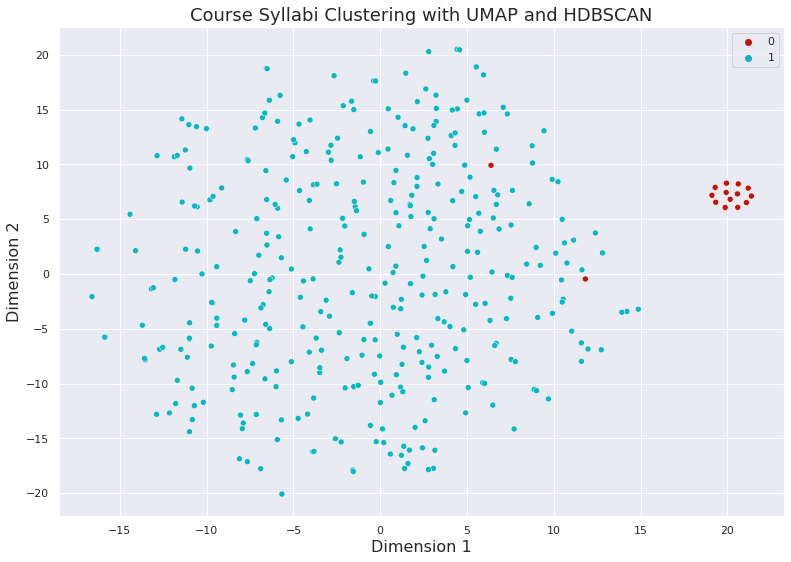

In [40]:


# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(no_clusters, l=.4, s=.9)

# plot
sns_plot = sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue = y_pred, legend = 'full', palette = palette)
plt.title('Course Syllabi Clustering with UMAP and HDBSCAN', fontsize = 18)
plt.xlabel('Dimension 1', fontsize = 16)
plt.ylabel('Dimension 2', fontsize = 16)
plt.show()
fig = sns_plot.get_figure()
fig.savefig('output.png')

The clustering based on the syllabi showes two big clusters. Basically the algorithm separates the online and the university courses to some extent but fails to establish subclusters. 

For this reason the clustering is repeated based on the course descriptions rather than the syllabi.

In [41]:
text = df["Processed_Description"].values

max_features = get_number_unique_words(descriptions)

X = vectorize(text, max_features)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [42]:
umap_embeddings = umap.UMAP(n_neighbors = 15, 
                            n_components = 5,
                            min_dist=0.0,
                            metric='cosine').fit_transform(X)

In [43]:
cluster = hdbscan.HDBSCAN(metric = 'euclidean',
                          min_cluster_size = 10,
                          cluster_selection_method='eom').fit(umap_embeddings)  

In [44]:
clusters = cluster.labels_.tolist()

In [45]:
frame ["Cluster"]=clusters

In [46]:
no_clusters = len(set(frame.Cluster))

In [47]:
y_pred = np.array(clusters) 

In [48]:
tsne = TSNE(verbose = 1, perplexity = 50)  
X_embedded = tsne.fit_transform(X.toarray())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 374 samples in 0.001s...
[t-SNE] Computed neighbors for 374 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 374 / 374
[t-SNE] Mean sigma: 0.302918
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.154037
[t-SNE] KL divergence after 1000 iterations: 1.099922


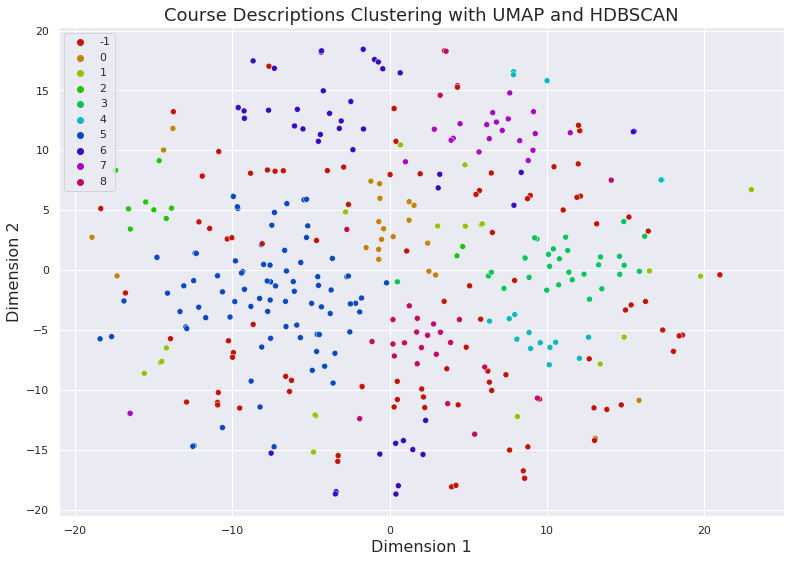

In [49]:
# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(no_clusters, l=.4, s=.9)

# plot
sns_plot = sns.scatterplot(x = X_embedded[:,0], y = X_embedded[:,1], hue = y_pred, legend = 'full', palette = palette)
plt.title('Course Descriptions Clustering with UMAP and HDBSCAN', fontsize = 18)
plt.xlabel('Dimension 1', fontsize = 16)
plt.ylabel('Dimension 2', fontsize = 16)
plt.show()
fig = sns_plot.get_figure()
fig.savefig('output.png')

This shows much better results and 8 distinguishable clusters as well as a cluster containing outliers are created. The clusters are all analyzed in the following Please note that rerunning the code changes the numbers of the clusters with the content reamaining the same. Therefore the comments will be not representing the actual cluster after rerunning.

## Cluster 0

In [50]:
filtr = (frame["Cluster"] == 0)
smokeframe0 = frame.loc[filtr].copy()

In [51]:
Smokefra0=smokeframe0.dropna(axis=0)

In [52]:
tex= Smokefra0["Syllabus"].to_list()

In [53]:
text=' '.join(tex)

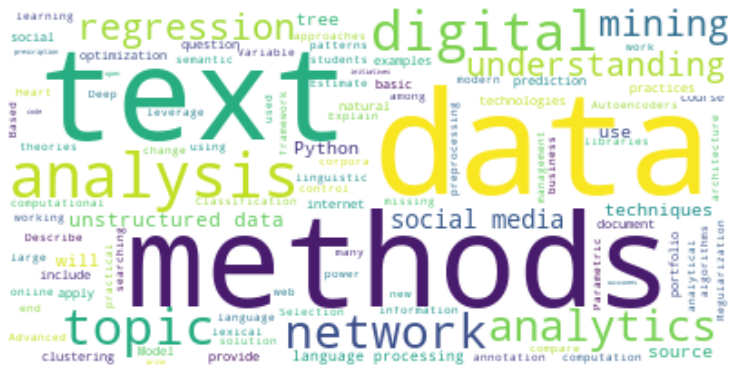

In [54]:

wc = WordCloud(max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


Cluster 0 contains mostly courses related to natural langauge processing and machine learning methods covering this. 

The courses were saved in list form for further reference. After that the most common n-grams are taken.

In [55]:
courselist0=smokeframe0["Course Title"]

In [57]:
processed = smokeframe0["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 1))
ngram_counts.most_common(10)

[(('text',), 32),
 (('datum',), 20),
 (('mining',), 16),
 (('course',), 13),
 (('method',), 10),
 (('use',), 9),
 (('social',), 9),
 (('practical',), 9),
 (('include',), 8),
 (('technique',), 8)]

In [58]:
processed = smokeframe0["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 2))
ngram_counts.most_common(10)

[(('social', 'medium'), 6),
 (('datum', 'mining'), 5),
 (('natural', 'language'), 4),
 (('text', 'datum'), 4),
 (('course', 'provide'), 3),
 (('topic', 'include'), 3),
 (('analysis', 'text'), 3),
 (('text', 'mining'), 3),
 (('data', 'science'), 3),
 (('investment', 'management'), 3)]

### Cluster 1

In [59]:
filtr = (frame["Cluster"] == 1)
smokeframe1 = frame.loc[filtr].copy()

In [60]:
smokeframe1

,University,Course Title,Short Description,Syllabus,Syllabus_punct,Description_punct,Processed_Syllabus,Processed_Description,Clusters,Cluster
109,St. Mary's University,UI/UX Design and Quality Engineering,"Students design, prototype and evaluate user i...",business analysis; human capabilities; interfa...,business analysis; human capabilities; interfa...,"Students design, prototype and evaluate user i...",business analysis human capability interface t...,student design prototype evaluate user interfa...,1,1
143,HEC Montreal,Implememtation of Business Optimization Models,Development of modeling skills from various ap...,Introduction to mathematical modelling Impleme...,Introduction to mathematical modelling Impleme...,Development of modeling skills from various ap...,introduction mathematical modelling implementa...,development model skill application logistics ...,1,1
164,McGill,Information Retreival,Theoretical and applied explanation of informa...,Theoretical and applied explanation of informa...,Theoretical and applied explanation of informa...,Theoretical and applied explanation of informa...,theoretical applied explanation information re...,theoretical applied explanation information re...,1,1
182,MIT,SSIM Ethics & Data Privacy,NaN,NaN,nan,nan,nan,nan,0,1
184,MIT,Communications and Data Storytelling Workshop,NaN,NaN,nan,nan,nan,nan,0,1
218,Carnegie Mellon University,Computer Networks,The emphasis in this course will be on the bas...,"network architecture, routing, congestion/flow...","network architecture, routing, congestion/flow...",The emphasis in this course will be on the bas...,network architecture routing congestion flow e...,emphasis course basic performance engineering ...,1,1
243,Carnegie Mellon University,Computational Forensiscs and AI,This course covers the use of computational me...,"By the end of the course, students will learn ...","By the end of the course, students will learn ...",This course covers the use of computational me...,end course student learn key technology use tr...,course cover use computational method crime in...,1,1
244,Carnegie Mellon University,Question Answering,The Question Answering course provides a chanc...,The Question Answering course provides a chanc...,The Question Answering course provides a chanc...,The Question Answering course provides a chanc...,question answering course provide chance hand ...,question answering course provide chance hand ...,1,1
246,Carnegie Mellon University,Machine Learning with Large Datasets,Large datasets pose difficulties across the ma...,"Distributed Computing, Spark Visualization, PC...","Distributed Computing, Spark Visualization, PC...",Large datasets pose difficulties across the ma...,distribute computing spark visualization pca n...,large dataset pose difficulty machine learn pi...,0,1
247,Carnegie Mellon University,Scalability in Machine Learning,The goal of this course is to provide a survey...,Large datasetsc Scaling up kernel and other ML...,Large datasetsc Scaling up kernel and other ML...,The goal of this course is to provide a survey...,large datasetsc scale kernel ml method large d...,goal course provide survey recent advance theo...,1,1


In [61]:
Smokefra1=smokeframe1.dropna(axis=0)

In [62]:
tex= Smokefra1["Syllabus"].to_list()

In [63]:
text=' '.join(tex)

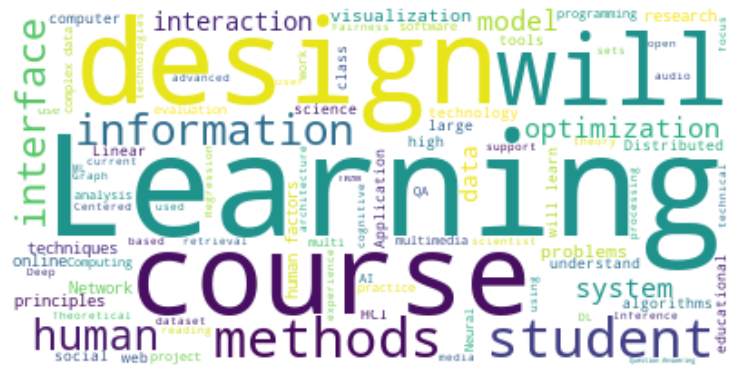

In [64]:

wc = WordCloud(max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


Cluster 1 is a bit more noisy, a tendency is viewed that this includes mostly courses related to the interaction between humans and data science (Data COllection, User Experience, Human Interaction, Social Data, Design Principles) but some courses related to machine learning are also featured. 

In [65]:
courselist1=smokeframe1["Course Title"]

In [67]:
processed = smokeframe1["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 1))
ngram_counts.most_common(10)

[(('human',), 25),
 (('design',), 22),
 (('course',), 16),
 (('student',), 15),
 (('information',), 12),
 (('learn',), 12),
 (('use',), 11),
 (('datum',), 11),
 (('system',), 11),
 (('computer',), 8)]

In [68]:
processed = smokeframe1["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 2))
ngram_counts.most_common(10)

[(('human', 'factor'), 6),
 (('machine', 'learning'), 4),
 (('design', 'principle'), 4),
 (('user', 'interface'), 3),
 (('large', 'dataset'), 3),
 (('use', 'variety'), 2),
 (('information', 'retrieval'), 2),
 (('interface', 'design'), 2),
 (('information', 'visualization'), 2),
 (('design', 'implementation'), 2)]

### Cluster 2

In [69]:
filtr = (frame["Cluster"] == 2)
smokeframe2 = frame.loc[filtr].copy()

In [70]:
Smokefra2=smokeframe2.dropna(axis=0)

In [71]:
tex= Smokefra2["Syllabus"].to_list()

In [72]:
text=' '.join(tex)

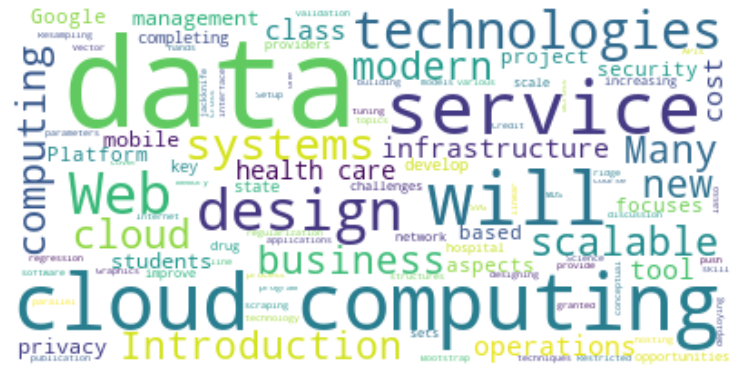

In [73]:

wc = WordCloud(max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


The courses in this cluster are mostly related to cloud computing and distributed systems as well as system infrastructure.

In [74]:
courselist2=smokeframe2["Course Title"]

In [76]:
processed = smokeframe2["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 1))
ngram_counts.most_common(10)

[(('cloud',), 26),
 (('datum',), 18),
 (('use',), 15),
 (('service',), 15),
 (('data',), 12),
 (('student',), 10),
 (('storage',), 9),
 (('computing',), 7),
 (('machine',), 7),
 (('model',), 7)]

In [77]:
processed = smokeframe2["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 2))
ngram_counts.most_common(10)

[(('cloud', 'storage'), 5),
 (('google', 'cloud'), 5),
 (('cloud', 'data'), 4),
 (('data', 'fusion'), 4),
 (('machine', 'learning'), 4),
 (('programming', 'model'), 3),
 (('hand', 'experience'), 3),
 (('health', 'care'), 3),
 (('web', 'platform'), 2),
 (('platform', 'datum'), 2)]

### Cluster 3

In [78]:
filtr = (frame["Cluster"] == 3)
smokeframe3 = frame.loc[filtr].copy()

In [80]:
Smokefra3=smokeframe3.dropna(axis=0)

In [81]:
tex= Smokefra3["Syllabus"].to_list()

In [82]:
text=' '.join(tex)

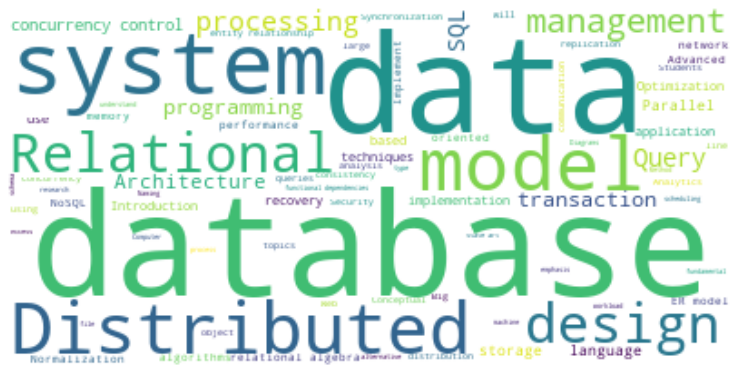

In [83]:

wc = WordCloud(max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


Besides distributed systems, cluster 3 covers databasess of all types. 

In [84]:
courselist3=smokeframe3["Course Title"]

In [86]:
processed = smokeframe3["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 1))
ngram_counts.most_common(10)

[(('database',), 60),
 (('system',), 54),
 (('datum',), 41),
 (('relational',), 24),
 (('distribute',), 21),
 (('design',), 21),
 (('management',), 19),
 (('use',), 19),
 (('data',), 17),
 (('query',), 17)]

In [87]:
processed = smokeframe3["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 2))
ngram_counts.most_common(10)

[(('relational', 'database'), 13),
 (('database', 'system'), 10),
 (('database', 'management'), 10),
 (('management', 'system'), 9),
 (('concurrency', 'control'), 9),
 (('distribute', 'system'), 7),
 (('e.', 'g.'), 6),
 (('query', 'processing'), 5),
 (('topic', 'include'), 5),
 (('datum', 'mining'), 4)]

### Cluster 4

In [88]:
filtr = (frame["Cluster"] == 4)
smokeframe4 = frame.loc[filtr].copy()

In [89]:
Smokefra4=smokeframe4.dropna(axis=0)

In [90]:
tex= Smokefra4["Syllabus"].to_list()

In [91]:
text=' '.join(tex)

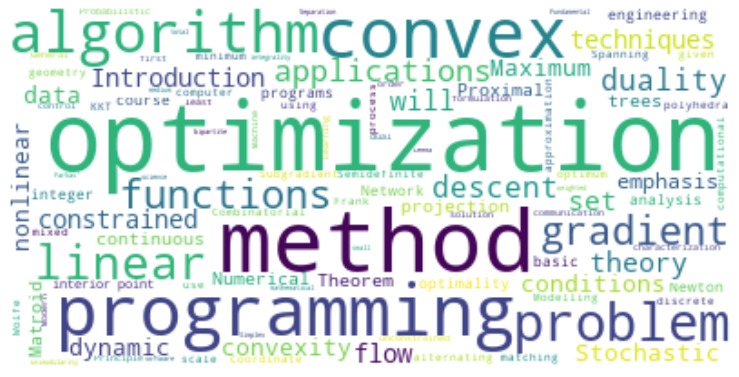

In [92]:

wc = WordCloud(max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


Cluster 4 is almost exclusively related to optimization techniques

In [96]:
courselist4=smokeframe4["Course Title"]

In [137]:
processed = smokeframe4["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 1))
ngram_counts.most_common(10)

[(('optimization',), 29),
 (('method',), 18),
 (('programming',), 17),
 (('algorithm',), 15),
 (('problem',), 12),
 (('linear',), 11),
 (('mathematical',), 9),
 (('convex',), 9),
 (('use',), 8),
 (('technique',), 7)]

In [98]:
processed = smokeframe4["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 2))
ngram_counts.most_common(10)

[(('machine', 'learning'), 4),
 (('linear', 'programming'), 4),
 (('optimization', 'problem'), 3),
 (('interior', 'point'), 3),
 (('point', 'method'), 3),
 (('nonconvex', 'optimization'), 3),
 (('gradient', 'descent'), 3),
 (('mathematical', 'programming'), 2),
 (('optimization', 'algorithm'), 2),
 (('algorithm', 'optimization'), 2)]

### Cluster 5

In [99]:
filtr = (frame["Cluster"] == 5)
smokeframe5 = frame.loc[filtr].copy()

In [101]:
processed = smokeframe5["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 1))
ngram_counts.most_common(10)

[(('datum',), 308),
 (('data',), 165),
 (('science',), 150),
 (('course',), 147),
 (('use',), 81),
 (('analysis',), 75),
 (('learn',), 74),
 (('python',), 72),
 (('skill',), 57),
 (('visualization',), 45)]

In [103]:
Smokefra5=smokeframe5.dropna(axis=0)

In [104]:
tex= Smokefra5["Syllabus"].to_list()

In [105]:
text=' '.join(tex)

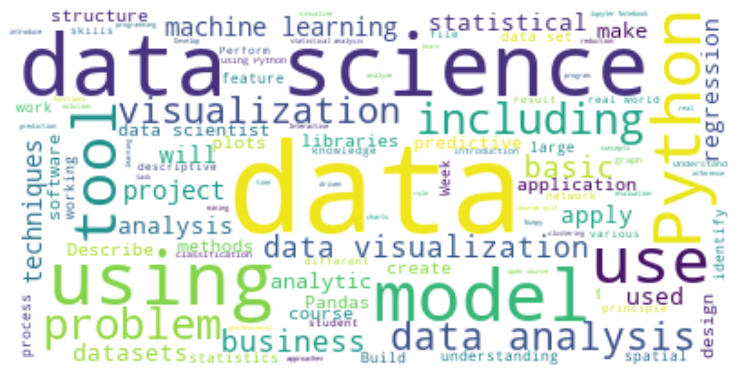

In [106]:

wc = WordCloud(max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


Cluster 5 is somewhat not clear and there are many general terms included. For this reason this cluster is considered noisy. Importnat is that skills such as python and visualizationa re included next to the generic term machine learning. 

In [107]:
courselist5=smokeframe5["Course Title"]

In [109]:
processed = smokeframe5["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 2))
ngram_counts.most_common(10)

[(('datum', 'science'), 71),
 (('data', 'science'), 54),
 (('datum', 'analysis'), 28),
 (('real', 'world'), 22),
 (('machine', 'learning'), 20),
 (('data', 'scientist'), 17),
 (('big', 'datum'), 14),
 (('datum', 'scientist'), 13),
 (('data', 'set'), 13),
 (('data', 'analysis'), 12)]

In [110]:
filtr = (frame["Cluster"] == 6)
smokeframe6 = frame.loc[filtr].copy()

### Cluster 6

In [111]:
Smokefra6=smokeframe6.dropna(axis=0)

In [112]:
tex= Smokefra6["Syllabus"].to_list()

In [113]:
text=' '.join(tex)

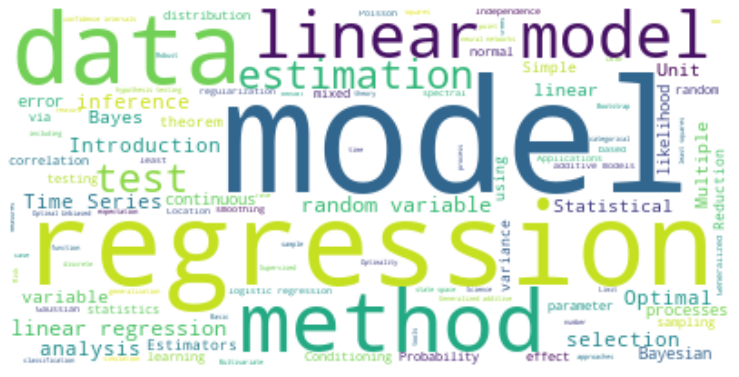

In [114]:

wc = WordCloud(max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


Courses in this cluster cover statistical concepts and statistical modelling.

In [115]:
courselist6=smokeframe6["Course Title"]

In [117]:
processed = smokeframe6["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 1))
ngram_counts.most_common(10)

[(('model',), 49),
 (('regression',), 33),
 (('linear',), 25),
 (('method',), 20),
 (('datum',), 19),
 (('variable',), 17),
 (('statistical',), 16),
 (('use',), 16),
 (('analysis',), 15),
 (('include',), 13)]

In [118]:
processed = smokeframe6["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 2))
ngram_counts.most_common(10)

[(('linear', 'regression'), 13),
 (('random', 'variable'), 7),
 (('regression', 'model'), 6),
 (('time', 'series'), 6),
 (('linear', 'model'), 5),
 (('cross', 'validation'), 4),
 (('discrete', 'continuous'), 4),
 (('series', 'model'), 4),
 (('statistical', 'inference'), 4),
 (('model', 'assessment'), 3)]

### Cluster 7

In [119]:
filtr = (frame["Cluster"] == 7)
smokeframe7 = frame.loc[filtr].copy()

In [120]:
Smokefra7=smokeframe7.dropna(axis=0)

In [121]:
tex= Smokefra7["Syllabus"].to_list()

In [122]:
text=' '.join(tex)

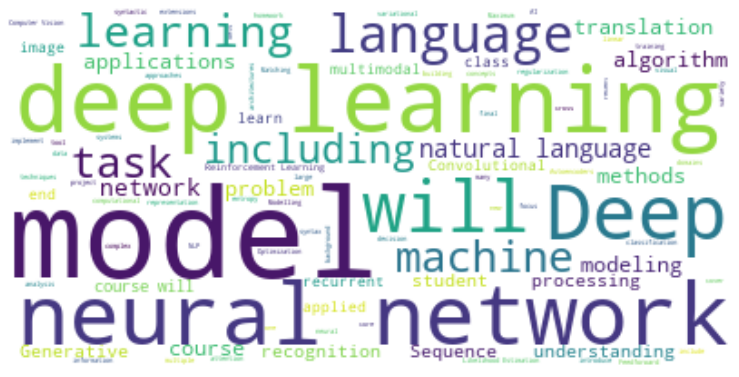

In [123]:

wc = WordCloud(max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


This cluster includes courses related to machine learning and here especially more advanced techniques such as deep learning. 

In [124]:
courselist7=smokeframe7["Course Title"]

In [125]:
processed = smokeframe7["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 1))
ngram_counts.most_common(10)

[(('language',), 34),
 (('learning',), 30),
 (('deep',), 29),
 (('network',), 27),
 (('neural',), 24),
 (('model',), 23),
 (('course',), 22),
 (('natural',), 14),
 (('machine',), 13),
 (('task',), 12)]

In [126]:
processed = smokeframe7["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 2))
ngram_counts.most_common(10)

[(('neural', 'network'), 22),
 (('deep', 'learning'), 17),
 (('natural', 'language'), 14),
 (('language', 'processing'), 8),
 (('machine', 'learning'), 6),
 (('machine', 'translation'), 4),
 (('language', 'understanding'), 4),
 (('speech', 'recognition'), 3),
 (('learning', 'recent'), 3),
 (('learning', 'include'), 3)]

### Cluster 8

In [127]:
filtr = (frame["Cluster"] == 8)
smokeframe8 = frame.loc[filtr].copy()

In [138]:
Smokefra8=smokeframe8.dropna(axis=0)

In [139]:
tex= Smokefra8["Syllabus"].to_list()

In [140]:
text=' '.join(tex)

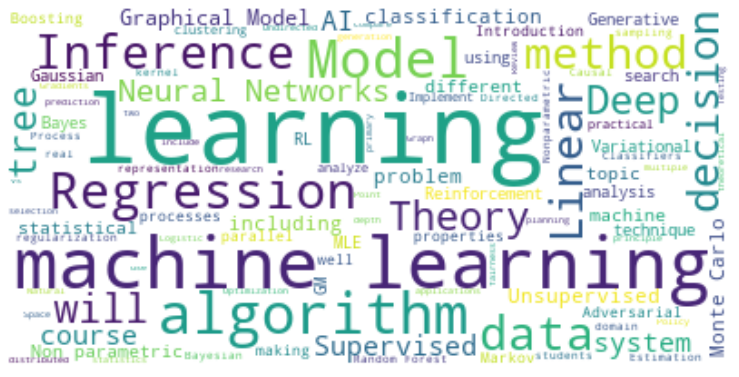

In [141]:

wc = WordCloud(max_words=100, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


In Comparison to the previous cluster this cluster mostly features more basic methods and introductions to Machine Learning methods.

In [129]:
processed = smokeframe8["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 1))
ngram_counts.most_common(10)

[(('learning',), 63),
 (('machine',), 52),
 (('algorithm',), 32),
 (('learn',), 29),
 (('course',), 25),
 (('use',), 19),
 (('include',), 16),
 (('computer',), 14),
 (('student',), 14),
 (('model',), 14)]

In [130]:
processed = smokeframe8["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 2))
ngram_counts.most_common(10)

[(('machine', 'learning'), 32),
 (('machine', 'learn'), 10),
 (('artificial', 'intelligence'), 6),
 (('algorithm', 'use'), 5),
 (('learning', 'algorithm'), 5),
 (('classification', 'regression'), 4),
 (('application', 'machine'), 4),
 (('learning', 'method'), 4),
 (('support', 'vector'), 3),
 (('natural', 'language'), 3)]

Finally some general n gram frequencies are calculated. However these only give limited information.

In [131]:
processed = df["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 2))
ngram_counts.most_common(10)

[(('datum', 'science'), 88),
 (('machine', 'learning'), 86),
 (('data', 'science'), 76),
 (('datum', 'analysis'), 33),
 (('real', 'world'), 32),
 (('neural', 'network'), 28),
 (('e.', 'g.'), 26),
 (('natural', 'language'), 26),
 (('deep', 'learning'), 23),
 (('machine', 'learn'), 22)]

In [132]:
processed = df["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 3))
ngram_counts.most_common(10)

[(('natural', 'language', 'processing'), 10),
 (('database', 'management', 'system'), 9),
 (('use', 'machine', 'learning'), 8),
 (('real', 'world', 'datum'), 8),
 (('certificate', 'program', 'data'), 8),
 (('program', 'data', 'science'), 8),
 (('large', 'data', 'set'), 7),
 (('course', 'introduce', 'student'), 7),
 (('use', 'real', 'world'), 7),
 (('machine', 'learning', 'algorithm'), 7)]

In [133]:
processed = df["Processed_Description"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 1))
ngram_counts.most_common(10)

[(('datum',), 537),
 (('course',), 310),
 (('data',), 260),
 (('use',), 227),
 (('science',), 224),
 (('learning',), 175),
 (('model',), 167),
 (('learn',), 163),
 (('analysis',), 155),
 (('machine',), 138)]

In [134]:
processed = df["Processed_Syllabus"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(),2))
ngram_counts.most_common(10)

[(('machine', 'learning'), 43),
 (('datum', 'science'), 32),
 (('data', 'science'), 27),
 (('neural', 'network'), 25),
 (('deep', 'learning'), 22),
 (('linear', 'regression'), 21),
 (('machine', 'learn'), 21),
 (('monte', 'carlo'), 19),
 (('data', 'analysis'), 17),
 (('linear', 'model'), 17)]

In [135]:
processed = df["Processed_Syllabus"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 1))
ngram_counts.most_common(10)

[(('datum',), 262),
 (('model',), 211),
 (('use',), 162),
 (('data',), 162),
 (('learning',), 135),
 (('method',), 118),
 (('analysis',), 115),
 (('regression',), 94),
 (('include',), 88),
 (('design',), 85)]

In [136]:
processed = df["Processed_Syllabus"].to_list()
processed='-'.join(processed)
ngram_counts = Counter(ngrams(processed.split(), 3))
ngram_counts.most_common(10)

[(('natural', 'language', 'processing'), 7),
 (('markov', 'decision', 'process'), 6),
 (('support', 'vector', 'machine'), 5),
 (('hide', 'markov', 'model'), 5),
 (('database', 'management', 'system'), 5),
 (('machine', 'learning', 'method'), 5),
 (('non', 'parametric', 'regression'), 5),
 (('use', 'machine', 'learn'), 5),
 (('multiple', 'linear', 'regression'), 4),
 (('generalize', 'additive', 'model'), 4)]